In [1]:
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Users/leon/Files/dscribe')
import dscribe
import dscribe.descriptors
#sys.path.insert(1, '/Users/leon/Files/dscribe/decriptors')
from dscribe.descriptors import SOAP
#from dscribe.descriptors import ACSF

In [2]:
import numpy as np
import os
from tqdm import tqdm

from ase.io import read
from ase.build import molecule
from ase import Atoms
from ase.visualize import view
import math
import sklearn
#import shap

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from collections import namedtuple


In [4]:
%ls

Dscribe Encode.ipynb    __pycache__/            feature_generation/
Invariance.ipynb        batch_job_submitter.sh  model.png
Untitled.ipynb          encode_data.py          soap_parameter_test.py


In [5]:
import csv

barriers = dict()

with open('../data/vaskas_features_properties_smiles_filenames.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        #images.append(row[0])
        #elos.append(row[1])
        barriers[row[93]] = float(row[91])

In [6]:
labels = []
elems = []
for f in tqdm(os.listdir("../data/coordinates_TS/")):
    if f.endswith(".xyz"):
        elems.append(read("../data/coordinates_TS/" + f))
        labels.append(barriers[f[:-7]])

labels = np.array(labels)

from sklearn.preprocessing import StandardScaler
barrierScaler = StandardScaler()
barrierScaler.fit(labels.reshape(-1, 1))
labels = barrierScaler.transform(labels.reshape(-1, 1))

100%|██████████| 1947/1947 [00:02<00:00, 872.99it/s] 


In [7]:
print(len(elems))

1947


In [8]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))


def length(v):
    return math.sqrt(dotproduct(v, v))


def angle(v1, v2):
    angle = np.arccos(dotproduct(v1, v2) / (length(v1) * length(v2)))
    if(np.amin(np.cross(v1,v2)) < 0):
        angle = -angle
    return(angle)

def cosAngle(v1, v2):
    return dotproduct(v1, v2) / (length(v1) * length(v2))


def sinAngle(v1, v2):
    return dotproduct(v1, v2) / (length(v1) * length(v2))


def get_rotation_matrix(mean):
    """
    Returns a rotation matrix that rotates the space so that mean is on the y axis, so mean has
    coordinates [0,0,z] after transformation.
    """
    
    # If mean is already alligned with z-axis rotation around z can be ignored
    if (mean[0] == 0 and mean[1] == 0):
        rotZ = [[1,0,0], [0,1,0], [0,0,1]]
    else:
        angleZ =  1 * (angle([1,0,0], [mean[0], mean[1], 0]))
        rotZ = np.matrix([[np.cos(angleZ),np.sin(angleZ), 0],
                          [-np.sin(angleZ), np.cos(angleZ), 0], 
                          [0, 0, 1]])

    angleY = 1 * (angle([0,0,1], mean))
    rotY = np.matrix([[np.cos(angleY), 0, np.sin(angleY)], 
                      [0,1,0], 
                      [-np.sin(angleY), 0, np.cos(angleY)]])
    
    rot = np.matmul(rotY, rotZ)
    
    result = np.array(rot) @ mean
    
    if result[0] > 1e-12:
        rotZ = np.matrix([[np.cos(-angleZ),np.sin(-angleZ), 0],
                          [-np.sin(-angleZ), np.cos(-angleZ), 0], 
                          [0, 0, 1]])
        rot = np.matmul(rotY, rotZ)
        
    return rot

In [9]:
np.degrees(angle((1,0,0), (0,0,1)))

-90.0

In [12]:
for p in range(10):
    for element in elems:
        mean = (element.get_positions()[1] - element.get_positions()[0])

        rotation = get_rotation_matrix(mean)
        positions = element.get_positions()

        for x in range(len(positions)):
            element.positions[x] = rotation @ (positions[x] - positions[0])

for p in range(10):
    for element in elems:
        mean = ((element.get_positions()[1] + element.get_positions()[2]) / 2) - element.get_positions()[0]

        rotation = get_rotation_matrix(mean)
        positions = element.get_positions()

        for x in range(len(positions)):
            element.positions[x] = rotation @ (positions[x] - positions[0])

In [97]:
import copy

def z_rotation(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0], [np.sin(angle), np.cos(angle), 0], [0,0,1]])

steps = np.arange(0, np.pi * 2, 0.5)

elems_ag = []
labels_ag = []

for element, label in zip(elems, labels):
    for step in steps:
        rotation = z_rotation(step)
        
        element_rotated = copy.deepcopy(element)
        
        positions = element_rotated.get_positions()
        for x in range(len(positions)):
            element_rotated.positions[x] = rotation @ positions[x]
        
        elems_ag.append(element_rotated)
        labels_ag.append(label)   
        
labels = labels_ag
elems = elems_ag

In [98]:
print(len(labels_ag))

25311


In [99]:
species = ["H","C","N","O","F","P","S","Cl","As","Br","I","Ir"]
#species = ["H"]
print(len(species))
rcut = 10.0
nmax = 3
lmax = 3

# Setting up the SOAP descriptor
soap = dscribe.descriptors.SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    rbf="gto"
)

print(soap.get_number_of_features())

12
Using custom library
2664


In [100]:
atom_index = [[0]] * len(elems)

#features_soap = soap.create(elems, positions=atom_index)

features_soap = soap.create_coeffs(elems, positions=atom_index)

Creating coeffs


In [101]:
#features_cnn = []
#for x in range(len(features_acsf)):
#    features_cnn.append(np.concatenate((features_soap[x], features_acsf[x])))
    
#features_cnn = np.array(features_cnn)

features_cnn = features_soap
print(features_cnn.shape)

(25311, 576)


In [102]:
from sklearn.preprocessing import StandardScaler
inputScaler = StandardScaler()
inputScaler.fit(features_cnn)
features_cnn = inputScaler.transform(features_cnn)

In [103]:
print(elems[0])
view(elems[0], viewer='x3d')

Atoms(symbols='IrH2NC2NC2H4C3H2CH3CH3N2CNHNCS', pbc=False)


In [104]:
print(len(features_cnn[0]))

ncenter = 1
# GTO:
nCoeffs = 100*len(species)*nmax*ncenter
# Poly:
# nCoeffs = ncenter * 2*(lmax+1)*(lmax+1)*nmax*len(species)
print(nCoeffs)

576
3600


In [105]:
#i: Center
i = 0

def get_c(features, Z, n, l, m): 
    NsTs100 = nmax*len(species)*100
    Ns100 = nmax*100
    offset = l*l + m
    coeffs_for_species = NsTs100*i + (lmax*lmax + 2*lmax) * nmax + nmax

    index = NsTs100*i + coeffs_for_species * Z + offset*nmax + n
    
    return features[NsTs100*i + coeffs_for_species * Z + offset*nmax + n]


In [106]:
from scipy.special import gamma
from scipy.linalg import sqrtm, inv

def get_basis_gto(rcut, nmax):
    """Used to calculate the alpha and beta prefactors for the gto-radial
    basis.

    Args:
        rcut(float): Radial cutoff.
        nmax(int): Number of gto radial bases.

    Returns:
        (np.ndarray, np.ndarray): The alpha and beta prefactors for all bases
        up to a fixed size of l=10.
    """
    # These are the values for where the different basis functions should decay
    # to: evenly space between 1 angstrom and rcut.
    a = np.linspace(1, rcut, nmax)
    threshold = 1e-3  # This is the fixed gaussian decay threshold

    alphas_full = np.zeros((10, nmax))
    betas_full = np.zeros((10, nmax, nmax))

    for l in range(0, 10):
        # The alphas are calculated so that the GTOs will decay to the set
        # threshold value at their respective cutoffs
        alphas = -np.log(threshold/np.power(a, l))/a**2

        # Calculate the overlap matrix
        m = np.zeros((alphas.shape[0], alphas.shape[0]))
        m[:, :] = alphas
        m = m + m.transpose()
        S = 0.5*gamma(l + 3.0/2.0)*m**(-l-3.0/2.0)

        # Get the beta factors that orthonormalize the set with Löwdin
        # orthonormalization
        betas = sqrtm(inv(S))

        # If the result is complex, the calculation is currently halted.
        if (betas.dtype == np.complex128):
            raise ValueError(
                "Could not calculate normalization factors for the radial "
                "basis in the domain of real numbers. Lowering the number of "
                "radial basis functions (nmax) or increasing the radial "
                "cutoff (rcut) is advised."
            )

        alphas_full[l, :] = alphas
        betas_full[l, :, :] = betas

    return alphas_full, betas_full


In [107]:
def get_basis_poly(rcut, nmax):
    """Used to calculate discrete vectors for the polynomial basis functions.

    Args:
        rcut(float): Radial cutoff.
        nmax(int): Number of polynomial radial bases.

    Returns:
        (np.ndarray, np.ndarray): Tuple containing the evaluation points in
        radial direction as the first item, and the corresponding
        orthonormalized polynomial radial basis set as the second item.
    """
    # Calculate the overlap of the different polynomial functions in a
    # matrix S. These overlaps defined through the dot product over the
    # radial coordinate are analytically calculable: Integrate[(rc - r)^(a
    # + 2) (rc - r)^(b + 2) r^2, {r, 0, rc}]. Then the weights B that make
    # the basis orthonormal are given by B=S^{-1/2}
    S = np.zeros((nmax, nmax), dtype=np.float64)
    for i in range(1, nmax+1):
        for j in range(1, nmax+1):
            S[i-1, j-1] = (2*(rcut)**(7+i+j))/((5+i+j)*(6+i+j)*(7+i+j))

    # Get the beta factors that orthonormalize the set with Löwdin
    # orthonormalization
    betas = sqrtm(np.linalg.inv(S))

    # If the result is complex, the calculation is currently halted.
    if (betas.dtype == np.complex128):
        raise ValueError(
            "Could not calculate normalization factors for the radial "
            "basis in the domain of real numbers. Lowering the number of "
            "radial basis functions (nmax) or increasing the radial "
            "cutoff (rcut) is advised."
        )

    # The radial basis is integrated in a very specific nonlinearly spaced
    # grid given by rx
    x = np.zeros(100)
    x[0] = -0.999713726773441234
    x[1] = -0.998491950639595818
    x[2] = -0.996295134733125149
    x[3] = -0.99312493703744346
    x[4] = -0.98898439524299175
    x[5] = -0.98387754070605702
    x[6] = -0.97780935848691829
    x[7] = -0.97078577576370633
    x[8] = -0.962813654255815527
    x[9] = -0.95390078292549174
    x[10] = -0.94405587013625598
    x[11] = -0.933288535043079546
    x[12] = -0.921609298145333953
    x[13] = -0.90902957098252969
    x[14] = -0.895561644970726987
    x[15] = -0.881218679385018416
    x[16] = -0.86601468849716462
    x[17] = -0.849964527879591284
    x[18] = -0.833083879888400824
    x[19] = -0.815389238339176254
    x[20] = -0.79689789239031448
    x[21] = -0.77762790964949548
    x[22] = -0.757598118519707176
    x[23] = -0.736828089802020706
    x[24] = -0.715338117573056447
    x[25] = -0.69314919935580197
    x[26] = -0.670283015603141016
    x[27] = -0.64676190851412928
    x[28] = -0.622608860203707772
    x[29] = -0.59784747024717872
    x[30] = -0.57250193262138119
    x[31] = -0.546597012065094168
    x[32] = -0.520158019881763057
    x[33] = -0.493210789208190934
    x[34] = -0.465781649773358042
    x[35] = -0.437897402172031513
    x[36] = -0.409585291678301543
    x[37] = -0.380872981624629957
    x[38] = -0.351788526372421721
    x[39] = -0.322360343900529152
    x[40] = -0.292617188038471965
    x[41] = -0.26258812037150348
    x[42] = -0.23230248184497397
    x[43] = -0.201789864095735997
    x[44] = -0.171080080538603275
    x[45] = -0.140203137236113973
    x[46] = -0.109189203580061115
    x[47] = -0.0780685828134366367
    x[48] = -0.046871682421591632
    x[49] = -0.015628984421543083
    x[50] = 0.0156289844215430829
    x[51] = 0.046871682421591632
    x[52] = 0.078068582813436637
    x[53] = 0.109189203580061115
    x[54] = 0.140203137236113973
    x[55] = 0.171080080538603275
    x[56] = 0.201789864095735997
    x[57] = 0.23230248184497397
    x[58] = 0.262588120371503479
    x[59] = 0.292617188038471965
    x[60] = 0.322360343900529152
    x[61] = 0.351788526372421721
    x[62] = 0.380872981624629957
    x[63] = 0.409585291678301543
    x[64] = 0.437897402172031513
    x[65] = 0.465781649773358042
    x[66] = 0.49321078920819093
    x[67] = 0.520158019881763057
    x[68] = 0.546597012065094168
    x[69] = 0.572501932621381191
    x[70] = 0.59784747024717872
    x[71] = 0.622608860203707772
    x[72] = 0.64676190851412928
    x[73] = 0.670283015603141016
    x[74] = 0.693149199355801966
    x[75] = 0.715338117573056447
    x[76] = 0.736828089802020706
    x[77] = 0.75759811851970718
    x[78] = 0.77762790964949548
    x[79] = 0.79689789239031448
    x[80] = 0.81538923833917625
    x[81] = 0.833083879888400824
    x[82] = 0.849964527879591284
    x[83] = 0.866014688497164623
    x[84] = 0.881218679385018416
    x[85] = 0.89556164497072699
    x[86] = 0.90902957098252969
    x[87] = 0.921609298145333953
    x[88] = 0.933288535043079546
    x[89] = 0.94405587013625598
    x[90] = 0.953900782925491743
    x[91] = 0.96281365425581553
    x[92] = 0.970785775763706332
    x[93] = 0.977809358486918289
    x[94] = 0.983877540706057016
    x[95] = 0.98898439524299175
    x[96] = 0.99312493703744346
    x[97] = 0.99629513473312515
    x[98] = 0.998491950639595818
    x[99] = 0.99971372677344123

    rx = rcut*0.5*(x + 1)

    # Calculate the value of the orthonormalized polynomial basis at the rx
    # values
    fs = np.zeros([nmax, len(x)])
    for n in range(1, nmax+1):
        fs[n-1, :] = (rcut-np.clip(rx, 0, rcut))**(n+2)

    gss = np.dot(betas, fs)

    return rx, gss

In [108]:
import numpy as np
from numpy import arctan2, sqrt
import numexpr as ne

def cart2sph(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arcsin(z / r)
    theta = np.arctan2(y, x)
    return phi, theta, r

In [64]:
from scipy.special import sph_harm

alpha, beta = get_basis_gto(rcut, nmax)

def radial_basis(r, n, l):    
    sum = 0    
    for n2 in range(0, nmax):
        sum += beta[l][n][n2] * (r**l) * np.exp(-1 * alpha[l][n] * r * r)

    return sum
    
def spherical_harm(theta, phi, l, m):
    #print("L: " + str(l) + ", M: " + str(m))
    return sph_harm(m, l, theta, phi).real

def density(features, Z, r, theta, phi):
    sum_real = 0
    sum_img = 0
    
    compromised_cs = 0
    
    for n in range(nmax):
        for l in range(lmax+1):
            for m in range(0, 2*l+1):
                #print("N: " + str(n) + ", L: " + str(l) + ", M: " + str(m))
                c = get_c(features, Z, n, l, m) * radial_basis(r, n, l) * spherical_harm(theta, phi, l, m)
                if np.isnan(c):
                    c = 0
                #print("C: " + str(get_c(features, Z, n, l, m)) + ", Rad: " + str(radial_basis(r, n, l)) + ", Sph: " + str(spherical_harm(theta, phi, l, m)))
                
                sum_real += c
                compromised_cs += 1
                #sum_img += get_c(features, Z, n, l, m)[1] * radial_basis(r, n, l) + spherical_harm(theta, phi, l, m)
    #print(compromised_cs)
    return sum_real

print(density(features_cnn[0], 0, 2, 2, 1))

-0.21347523751179334


In [65]:
print(np.amax(features_cnn[0]))

4.381556902413061


In [66]:
cart2sph(1,1,0)

(0.0, 0.7853981633974483, 1.4142135623730951)

In [40]:
from ase.build import molecule

# Molecule created as an ASE.Atoms
water = molecule("H2O")

water.positions[0] = (-2,2,2)
water.positions[1] = (2,2,2)
water.positions[2] = (0,0,0)

#print(water.get_positions())

# Create SOAP output for the system
soap_water = soap.create_coeffs(water, positions=[0])

features_cnn = soap_water.reshape(1,-1)
print(features_cnn.shape)
view(water, viewer='x3d')

Creating coeffs
Start: 0, End: 18
Start: 200, End: 218
Start: 400, End: 418
Start: 600, End: 618
Start: 800, End: 818
Start: 1000, End: 1018
Start: 1200, End: 1218
Start: 1400, End: 1418
Start: 1600, End: 1618
Start: 1800, End: 1818
Start: 2000, End: 2018
Start: 2200, End: 2218
(1, 216)


In [67]:
import plotly.graph_objects as go

usedIndices = np.zeros(2400)

X, Y, Z = np.mgrid[-8:8:10j, -8:8:10j, -8:8:10j]
print(len(features_cnn[0]))
element_index = species.index("C")
print(element_index)
values = []
for x in tqdm(range(-10, 10, 2)):
    for y in range(-10, 10, 2):
        for z in range(-10, 10, 2):
            phi, theta, r = cart2sph(x,y,z)
            density_c = density(features_cnn[0], element_index, r, theta, phi)
            values.append(density_c)
            
values = np.array(values)
#print(values)
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values,
    isomin=0,
    isomax=np.amax(values),
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=30, # needs to be a large number for good volume rendering
    ))
fig.show()

  0%|          | 0/10 [00:00<?, ?it/s]

576
1


 50%|█████     | 5/10 [00:01<00:01,  4.22it/s]/Users/leon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


In [49]:
print(features_cnn[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [247]:
IndexTouple = namedtuple('IndexTouple', ['center', 'species1', 'species2', 'l', 'n1', 'n2'])

indices = []

centers = 1
for Hs in range(centers):
    for Z1 in range(len(species)):
        for Z2 in range(Z1, len(species)):
            if Z1 == Z2:
                for l in range(lmax+1):
                    for N1 in range(nmax):
                        for N2 in range(N1, nmax):
                            indices.append(IndexTouple(Hs, Z1, Z2, l,N1,N2))
            else:
                for l in range(lmax+1):
                    for N1 in range(nmax):
                        for N2 in range(nmax):
                            indices.append(IndexTouple(Hs, Z1, Z2, l,N1,N2))

print(indices)
print(len(features_soap[0]))

[IndexTouple(center=0, species1=0, species2=0, l=0, n1=0, n2=0), IndexTouple(center=0, species1=0, species2=0, l=0, n1=0, n2=1), IndexTouple(center=0, species1=0, species2=0, l=0, n1=1, n2=1), IndexTouple(center=0, species1=0, species2=0, l=1, n1=0, n2=0), IndexTouple(center=0, species1=0, species2=0, l=1, n1=0, n2=1), IndexTouple(center=0, species1=0, species2=0, l=1, n1=1, n2=1), IndexTouple(center=0, species1=0, species2=0, l=2, n1=0, n2=0), IndexTouple(center=0, species1=0, species2=0, l=2, n1=0, n2=1), IndexTouple(center=0, species1=0, species2=0, l=2, n1=1, n2=1), IndexTouple(center=0, species1=0, species2=1, l=0, n1=0, n2=0), IndexTouple(center=0, species1=0, species2=1, l=0, n1=0, n2=1), IndexTouple(center=0, species1=0, species2=1, l=0, n1=1, n2=0), IndexTouple(center=0, species1=0, species2=1, l=0, n1=1, n2=1), IndexTouple(center=0, species1=0, species2=1, l=1, n1=0, n2=0), IndexTouple(center=0, species1=0, species2=1, l=1, n1=0, n2=1), IndexTouple(center=0, species1=0, speci

In [35]:
features_soap.shape

(1947, 432)

In [36]:
def k_inv(l, rCut):
    value = 1 / (np.pi * np.sqrt(8.0/(2.0*l + 1.0)) * 39.478417604 * rCut * rCut)
    #print("K_inv: " + str(value))
    return value

In [37]:
def get_c(z, n, l, features, indices, previous_cs):
    previous_cs = np.array(previous_cs)
    p = features[indices.index(IndexTouple(0, z, z, l, n, n))]
    #print("P: " + str(p))
    s = p * k_inv(l, rcut)
    #print(np.sum(previous_cs **2))
    return np.sqrt(s - np.sum(previous_cs **2))

In [ ]:
view(elems[2], viewer='x3d')

In [ ]:
print(features_soap[2])

In [ ]:
def gauss_orbital(r,n,l,nmax):
    sum = 0
    for n_c in range(1,nmax):
        

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

import plotly.graph_objects as go
from plotly.subplots import make_subplots

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

fig = make_subplots(rows=3, cols=3,
                    specs=[[{'is_3d': True},{'is_3d': True},{'is_3d': True}],[{'is_3d': True},{'is_3d': True},{'is_3d': True}],[{'is_3d': True},{'is_3d': True},{'is_3d': True}]],
                    subplot_titles=['Color corresponds to z', 'Color corresponds to distance to origin'],)

for l in range(3):              
    for m in range(3):
        # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
        fcolors = sph_harm(m, l, theta, phi).real
        fmax, fmin = fcolors.max(), fcolors.min()
        fcolors = (fcolors - fmin)/(fmax - fmin)


        fig.add_trace(go.Surface(x=x, y=y, z=z, surfacecolor=fcolors), l+1, m+1)

fig.update_layout(title_text="Ring cyclide")
fig.show()


In [ ]:
print(features_acsf.shape)

In [ ]:
#features_cnn = []
#for x in range(len(features_acsf)):
#    features_cnn.append(np.concatenate((features_soap[x], features_acsf[x])))
    
#features_cnn = np.array(features_cnn)

features_cnn = features_soap

In [374]:
print(elems[987][1])
print(elems[987][2])

Atom('H', [0.46784989259766685, -0.08728080039328932, 1.6368696102646836], index=1)
Atom('H', [-0.46784989259766774, 0.08728080039328937, 1.7820569942490776], index=2)


In [112]:
print(features_cnn.shape)
labels = np.array(labels)
print(labels.shape)

(25311, 576)
(25311, 1)


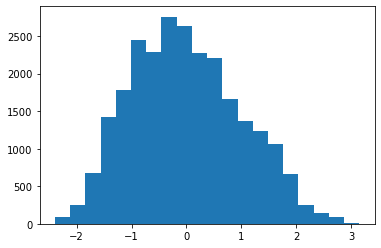

-1.8078682068251137e-16


In [113]:
import matplotlib.pyplot as plt

plt.hist(labels, bins = 20)
plt.show()

print(np.mean(labels))

In [114]:
def reg_stats(y_true,y_pred,scaler=None):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  if scaler:
    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
  r2 = sklearn.metrics.r2_score(y_true,y_pred)
  mae = sklearn.metrics.mean_absolute_error(y_true_unscaled, y_pred_unscaled)
  return r2,mae

In [115]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [116]:
(trainX_cnn, testX_cnn, trainY, testY) = train_test_split(features_cnn, labels, test_size=0.2, random_state=32)

In [117]:
inputs = tf.keras.Input(shape=(features_cnn.shape[1],))

x = tf.keras.layers.Dense(300, activation="relu", kernel_regularizer=regularizers.l2(0.05))(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.Dense(300, activation="relu", kernel_regularizer=regularizers.l2(0.02))(inputs)
#x = tf.keras.layers.Dropout(0.5)(x)
#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.03))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.02))(x)
#x = tf.keras.layers.Dropout(0.5)(x)
#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(1, kernel_regularizer='l2')(x)

model_full = tf.keras.Model(inputs=inputs, outputs=x)


In [118]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.RMSprop(learning_rate=0.0001)
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0)
model_full.compile(loss="mean_squared_error", optimizer=opt)

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.6
   epochs_drop = 80.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   #print(lrate)
   return lrate

In [ ]:
H = model_full.fit(x=trainX_cnn, y=trainY, validation_data=(testX_cnn, testY), epochs=800, batch_size=60, verbose=2, callbacks = [tf.keras.callbacks.LearningRateScheduler(step_decay)])

Epoch 1/800
338/338 - 2s - loss: 13.2393 - val_loss: 4.1554
Epoch 2/800
338/338 - 2s - loss: 2.1344 - val_loss: 1.0317
Epoch 3/800
338/338 - 2s - loss: 0.8864 - val_loss: 0.6870
Epoch 4/800
338/338 - 2s - loss: 0.6985 - val_loss: 0.5785
Epoch 5/800
338/338 - 2s - loss: 0.6503 - val_loss: 0.5706
Epoch 6/800
338/338 - 1s - loss: 0.6469 - val_loss: 0.5689
Epoch 7/800
338/338 - 1s - loss: 0.6295 - val_loss: 0.5429
Epoch 8/800
338/338 - 2s - loss: 0.6434 - val_loss: 0.6266
Epoch 9/800
338/338 - 1s - loss: 0.6644 - val_loss: 0.5803
Epoch 10/800
338/338 - 1s - loss: 0.6635 - val_loss: 0.5554
Epoch 11/800
338/338 - 2s - loss: 0.6675 - val_loss: 0.5656
Epoch 12/800
338/338 - 2s - loss: 0.6641 - val_loss: 0.6032
Epoch 13/800
338/338 - 1s - loss: 0.6730 - val_loss: 0.5962
Epoch 14/800
338/338 - 2s - loss: 0.6784 - val_loss: 0.6243
Epoch 15/800
338/338 - 2s - loss: 0.6784 - val_loss: 0.6078
Epoch 16/800
338/338 - 1s - loss: 0.6809 - val_loss: 0.5889
Epoch 17/800
338/338 - 1s - loss: 0.6758 - val_l

338/338 - 1s - loss: 0.3930 - val_loss: 0.2972
Epoch 138/800
338/338 - 2s - loss: 0.3870 - val_loss: 0.2885
Epoch 139/800
338/338 - 2s - loss: 0.3862 - val_loss: 0.2915
Epoch 140/800
338/338 - 2s - loss: 0.3808 - val_loss: 0.3017
Epoch 141/800
338/338 - 2s - loss: 0.3874 - val_loss: 0.2885
Epoch 142/800
338/338 - 2s - loss: 0.3876 - val_loss: 0.2840
Epoch 143/800
338/338 - 2s - loss: 0.3945 - val_loss: 0.3197
Epoch 144/800
338/338 - 2s - loss: 0.4013 - val_loss: 0.3101
Epoch 145/800
338/338 - 2s - loss: 0.3803 - val_loss: 0.3000
Epoch 146/800
338/338 - 1s - loss: 0.3805 - val_loss: 0.2931
Epoch 147/800
338/338 - 1s - loss: 0.3856 - val_loss: 0.3077
Epoch 148/800
338/338 - 2s - loss: 0.3890 - val_loss: 0.3197
Epoch 149/800
338/338 - 1s - loss: 0.4094 - val_loss: 0.3100
Epoch 150/800
338/338 - 1s - loss: 0.3733 - val_loss: 0.2925
Epoch 151/800
338/338 - 1s - loss: 0.3859 - val_loss: 0.2941
Epoch 152/800
338/338 - 1s - loss: 0.3826 - val_loss: 0.2991
Epoch 153/800
338/338 - 1s - loss: 0.3

In [ ]:
model_full.summary()
#tf.keras.utils.plot_model(model_full)
plot_loss(H)

In [ ]:
print("R^2 Train: " + str(reg_stats(trainY, model_full.predict(trainX_cnn), barrierScaler)[0]))
print("MAE Train: " + str(reg_stats(trainY, model_full.predict(trainX_cnn), barrierScaler)[1]))
print("")
print("R^2 Test: " + str(reg_stats(testY, model_full.predict(testX_cnn), barrierScaler)[0]))
print("MAE Test: " + str(reg_stats(testY, model_full.predict(testX_cnn), barrierScaler)[1]))

train_y_pred = barrierScaler.inverse_transform(model_full.predict(trainX_cnn))
train_y_real = barrierScaler.inverse_transform(trainY)

test_y_pred = barrierScaler.inverse_transform(model_full.predict(testX_cnn))
test_y_real = barrierScaler.inverse_transform(testY)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_y_real, train_y_pred, marker="o", c="C1", label="Training")
ax.scatter(test_y_real, test_y_pred, marker="o", c="C3", label="Validation")
ax.set_aspect('equal')
ax.set_xlabel("Calculated barrier [kcal/mol]")
ax.set_ylabel("Predicted barrier [kcal/mol]")
ax.legend(loc="upper left")

plt.show()

In [ ]:
shap.initjs()

In [ ]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

explainer = shap.DeepExplainer(model_full, trainX_cnn[:100])
shap_values = explainer.shap_values(testX_cnn[:100])
shap.summary_plot(shap_values, testX_cnn, plot_type='bar')

In [ ]:
def f(X):
    return model_full.predict(X).flatten()

feature_no = 23
explainer = shap.KernelExplainer(f, testX_cnn[:20])
shap_values = explainer.shap_values(testX_cnn[feature_no:(feature_no+1)], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, testX_cnn[feature_no:(feature_no+1)])